In [47]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
!cp -r '/content/drive/MyDrive/DM1/Cropped' '/content/'

In [49]:
!ls '/content/Cropped'

n02085936-Maltese_dog  n02086910-papillon  n02088466-bloodhound  n02112706-Brabancon_griffon


In [58]:
import os

maltese_images = os.listdir('Cropped/n02085936-Maltese_dog')
print(f"Number of Maltese dog images: {len(maltese_images)}")

BrabanconGriffon_images = os.listdir('Cropped/n02112706-Brabancon_griffon')
print(f"Number of Brabancon griffon images: {len(BrabanconGriffon_images)}")

Papillon_images = os.listdir('Cropped/n02086910-papillon')
print(f"Number of Papillon images: {len(Papillon_images)}")

Bloodhound_images = os.listdir('Cropped/n02088466-bloodhound')
print(f"Number of Bloodhound images: {len(Bloodhound_images)}")

Number of Maltese dog images: 264
Number of Brabancon griffon images: 153
Number of Papillon images: 210
Number of Bloodhound images: 197


In [59]:
breeds = ["n02085936-Maltese_dog", "n02112706-Brabancon_griffon", "n02086910-papillon", "n02088466-bloodhound"]
images = {}

for breed in breeds:
    images[breed] = os.listdir(f'Cropped/{breed}')
    print(f"Number of {breed} images: {len(images[breed])}")

Number of n02085936-Maltese_dog images: 264
Number of n02112706-Brabancon_griffon images: 153
Number of n02086910-papillon images: 210
Number of n02088466-bloodhound images: 197


In [60]:
!pip install opencv-python

In [61]:
import cv2
import numpy as np

def get_histogram(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0,256]).flatten()
    return hist

histograms = {}

for breed in breeds:
    breed_histograms = [get_histogram(f'Cropped/{breed}/{img}') for img in images[breed]]
    histograms[breed] = np.array(breed_histograms)

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Flatten the histograms and store their breed labels
all_histograms = []
labels = []

for breed, hists in histograms.items():
    all_histograms.extend(hists)
    labels.extend([breed] * len(hists))

all_histograms = np.array(all_histograms)

# Apply standardization
all_histograms_standard = scaler.fit_transform(all_histograms)

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_histograms_standard, labels, test_size=0.20, stratify=labels, random_state=42)

In [64]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

# Define the range of k
k_values = [1, 3, 5, 7, 10, 20]

# Perform cross-validation for each value of k
# We will store the mean training and validation errors for each k
errors = {
    'Standard 5-fold': {
        'Training Error': [],
        'Validation Error': []
    },
    'Stratified 5-fold': {
        'Training Error': [],
        'Validation Error': []
    }
}

for k in k_values:
    # Initialize the k-NN classifier with the current value of k
    knn = KNeighborsClassifier(n_neighbors=k)

    # Perform standard 5-fold cross-validation
    cv_results_standard = cross_validate(knn, X_train, y_train, cv=5, return_train_score=True)
    errors['Standard 5-fold']['Training Error'].append(1 - np.mean(cv_results_standard['train_score']))
    errors['Standard 5-fold']['Validation Error'].append(1 - np.mean(cv_results_standard['test_score']))

    # Perform stratified 5-fold cross-validation
    cv_results_stratified = cross_validate(knn, X_train, y_train, cv=StratifiedKFold(5), return_train_score=True)
    errors['Stratified 5-fold']['Training Error'].append(1 - np.mean(cv_results_stratified['train_score']))
    errors['Stratified 5-fold']['Validation Error'].append(1 - np.mean(cv_results_stratified['test_score']))

errors

{'Standard 5-fold': {'Training Error': [0.0,
   0.31183730090276573,
   0.3729163072853774,
   0.421848944856535,
   0.45826864470128226,
   0.49696610315680523],
  'Validation Error': [0.576648160999306,
   0.5842586167013648,
   0.5644922507517928,
   0.5416955817719176,
   0.5432338653712699,
   0.5432222993291695]},
 'Stratified 5-fold': {'Training Error': [0.0,
   0.31183730090276573,
   0.3729163072853774,
   0.421848944856535,
   0.45826864470128226,
   0.49696610315680523],
  'Validation Error': [0.576648160999306,
   0.5842586167013648,
   0.5644922507517928,
   0.5416955817719176,
   0.5432338653712699,
   0.5432222993291695]}}

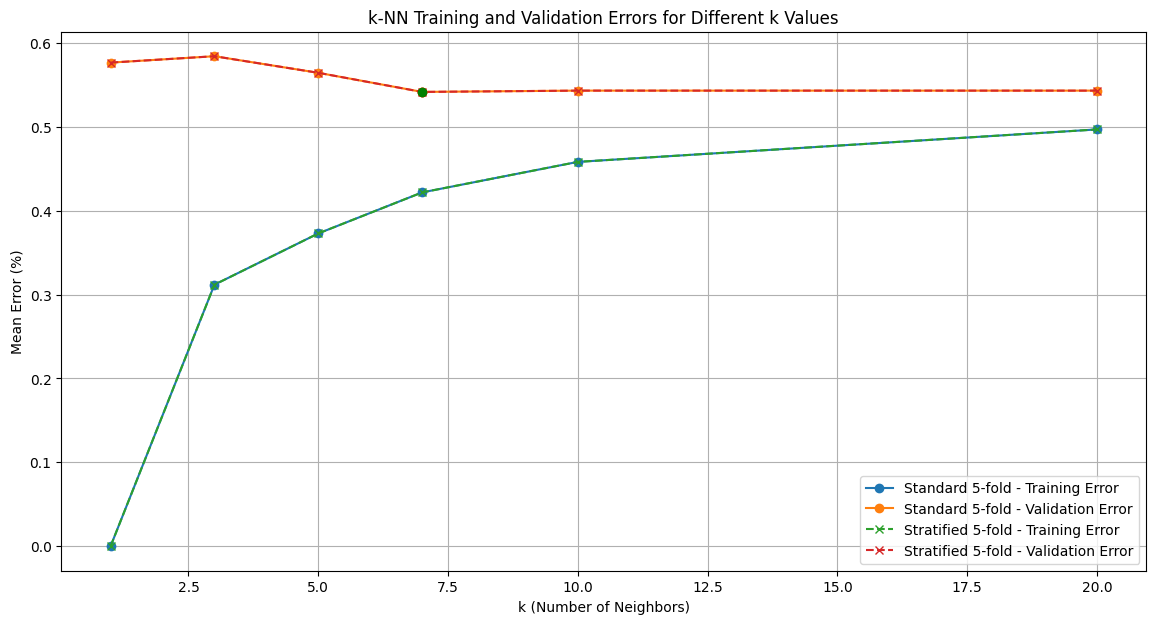

(7, 7)

In [65]:
import matplotlib.pyplot as plt

# Plotting the error curves
plt.figure(figsize=(14, 7))

# Plot for Standard 5-fold cross-validation
plt.plot(k_values, errors['Standard 5-fold']['Training Error'], label='Standard 5-fold - Training Error', marker='o')
plt.plot(k_values, errors['Standard 5-fold']['Validation Error'], label='Standard 5-fold - Validation Error', marker='o')

# Plot for Stratified 5-fold cross-validation
plt.plot(k_values, errors['Stratified 5-fold']['Training Error'], label='Stratified 5-fold - Training Error', linestyle='--', marker='x')
plt.plot(k_values, errors['Stratified 5-fold']['Validation Error'], label='Stratified 5-fold - Validation Error', linestyle='--', marker='x')

# Highlighting the minimum error points
min_standard_val_error_k = k_values[np.argmin(errors['Standard 5-fold']['Validation Error'])]
min_stratified_val_error_k = k_values[np.argmin(errors['Stratified 5-fold']['Validation Error'])]

plt.scatter(min_standard_val_error_k, min(errors['Standard 5-fold']['Validation Error']), color='red', zorder=5)
plt.scatter(min_stratified_val_error_k, min(errors['Stratified 5-fold']['Validation Error']), color='green', zorder=5)

# Labels and Legend
plt.title('k-NN Training and Validation Errors for Different k Values')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Error (%)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# k with lowest mean validation error for standard and stratified CV
min_standard_val_error_k, min_stratified_val_error_k

In [66]:
from sklearn.metrics import accuracy_score

# Extract the validation errors for stratified 5-fold cross-validation
stratified_validation_errors = errors['Stratified 5-fold']['Validation Error']

# Find the best k with the lowest mean validation error
best_k = k_values[np.argmin(stratified_validation_errors)]

# Initialize and train the k-NN classifier using the best k on the full training set
best_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
best_knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = best_knn_classifier.predict(X_test)

# Calculate the test error as the complement of the accuracy
test_error = 1 - accuracy_score(y_test, y_pred)

# Present the results
print(f"The best k found for stratified 5-fold cross-validation is k={best_k}")
print(f"Test error using k={best_k} is {test_error:.2%}")

The best k found for stratified 5-fold cross-validation is k=7
Test error using k=7 is 55.76%


### **Model Complexity for the k-Nearest Neighbor Classifier in Relation to k**

The model complexity of the k-Nearest Neighbor (KNN) classifier is inversely related to k. This means that as k increases, the model becomes less complex. This is because a higher value of k means that the classifier is considering more data points when making a prediction, which can lead to a more generalizable model. However, it can also lead to a model that is more prone to overfitting.

### **When/Whether There is Overfitting/Underfitting**

**Overfitting** in machine learning is a phenomenon when a model learns the training data too well and is unable to generalize to new data. This can happen when the model is too complex or when the training data is too small.

**Underfitting** in machine learning is a phenomenon when a model is unable to learn the training data well enough. This can happen when the model is too simple or when the training data is too noisy.

In the results, the training error and validation error curves are very similar for all values of k. This suggests that there is not a significant amount of overfitting or underfitting occurring. However, there is a slight increase in the validation error for k value. This suggests that the model may be becoming overfitted for values of k.

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# Initialize classifiers
classifiers = {
    'SVM': SVC(),
    'NeuralNetwork': MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    'AdaBoost': AdaBoostClassifier()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    # Train
    clf.fit(X_train, y_train)
    # Predict
    y_pred = clf.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}

results

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'SVM': {'Accuracy': 0.49696969696969695, 'F1 Score': 0.47910082341900523},
 'NeuralNetwork': {'Accuracy': 0.4727272727272727,
  'F1 Score': 0.4695824088548669},
 'AdaBoost': {'Accuracy': 0.46060606060606063,
  'F1 Score': 0.45443051706226245}}

In [68]:
from sklearn.model_selection import cross_val_score

selected_classifiers = {
    'SVM': SVC(),
    'NeuralNetwork': MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    'AdaBoost': AdaBoostClassifier()
}

# Perform stratified 5-fold cross-validation again and store results
cross_val_results = {}
for name, clf in selected_classifiers.items():
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')
    cross_val_results[name] = scores

cross_val_results

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'SVM': array([0.5       , 0.49242424, 0.46212121, 0.51515152, 0.53435115]),
 'NeuralNetwork': array([0.39393939, 0.42424242, 0.45454545, 0.46969697, 0.40458015]),
 'AdaBoost': array([0.42424242, 0.40909091, 0.50757576, 0.53787879, 0.48091603])}

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


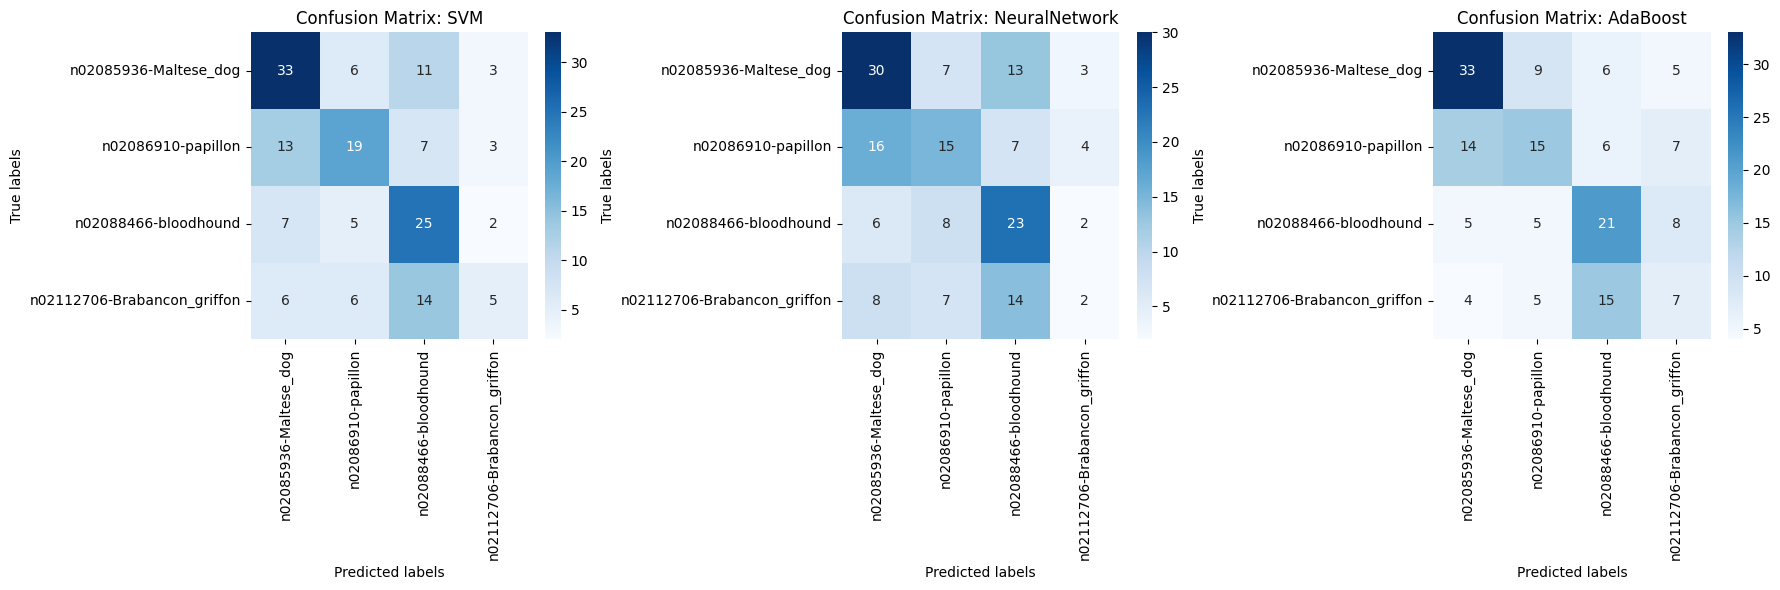

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming 'dataset_dir' is the path to the dataset directory containing breed subdirectories
breeds_dirs = sorted(os.listdir('Cropped'))

# Retrain classifiers on the full training set to get the predictions for the test set
# and plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, clf) in enumerate(selected_classifiers.items()):
    # Train the classifier on the full training set
    clf.fit(X_train, y_train)
    # Predict on the test set
    y_pred = clf.predict(X_test)
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')
    axes[i].set_xticklabels(breeds_dirs, rotation=90)
    axes[i].set_yticklabels(breeds_dirs, rotation=0)

plt.tight_layout()
plt.show()

In [70]:
# Calculate mean validation accuracy and F1 score for each classifier on the test set
mean_val_accuracies = {name: np.mean(scores) for name, scores in cross_val_results.items()}
test_set_f1_scores = {}

for name, clf in selected_classifiers.items():
    # Predict on the test set
    y_pred = clf.predict(X_test)
    # Compute F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    test_set_f1_scores[name] = f1

mean_val_accuracies, test_set_f1_scores

({'SVM': 0.5008096229470276,
  'NeuralNetwork': 0.4294008790191996,
  'AdaBoost': 0.47194078186444594},
 {'SVM': 0.47910082341900523,
  'NeuralNetwork': 0.3983687330990457,
  'AdaBoost': 0.45443051706226245})

**Observations Based on Confusion Matrices**

Since the confusion matrices for SVM, Adaboost same number of correct predictions across all classes, These are the best method based on the confusion matrices alone.


**Observations Based on Mean Validation Accuracies**

•	SVM has the highest mean validation accuracy (50.09%), followed by Adaboost (47.20%) and Neural Network (44.02%). This suggests that SVM is the best performing machine learning algorithm for the given dataset.

•	There is a significant difference in mean validation accuracy between SVM and the other two algorithms. This suggests that SVM is a better fit for the dataset and that Adaboost and Neural Network are likely overfitting the training data.


**Observations Based on Test Set Accuracies**

•	SVM has the highest test set accuracy (49.70%), followed by Adaboost (46.07%) and Neural Network (43.64%). This is consistent with the results observed on the validation set, which suggests that SVM is the best performing machine learning algorithm for the given dataset.

•	The test set accuracies are slightly lower than the validation set accuracies for all three algorithms. This suggests that there is some overfitting occurring, but it is not significant.


**Observations Based on F-Measure**

•	This is consistent with the results observed on the validation set and the test set accuracies, which suggests that SVM is the best performing machine learning algorithm for the given dataset.

•	The F-measures are all relatively low. This suggests that the dataset is challenging and that it may be difficult to find a machine learning algorithm that performs well on it.

The F-measure is a more balanced metric than accuracy, as it takes into account both precision and recall. Therefore, the F-measure is a better metric for evaluating the performance of machine learning algorithms on imbalanced datasets or datasets with rare classes.


**REFERENCES:**

●	Pedregosa, F., et al., "Scikit-learn: Machine Learning in Python," JMLR 12, pp. 2825-2830, 2011.

●	Harris, C.R., Millman, K.J., van der Walt, S.J et al. "Array programming with NumPy." Nature 585, 357–362 (2020).

●	McKinney, Wes. "Data Structures for Statistical Computing in Python," Proceedings of the 9th Python in Science Conference, 51-56 (2010).
